### Importing Libraries

In [ ]:
from PIL import Image
import os
import numpy as np
from numpy import cov, asarray
from pathlib import Path
from itertools import chain
import torch
from numpy import trace

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

### Preparing the Training Set

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(len(train_images), 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

11490434/11490434 [==============================] - 0s 0us/step


### The Generator and Discriminator Sub-Networks

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Hyper-parameters

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
EPOCHS = 60
global num_examples_to_generate
num_examples_to_generate = 64
noise_dim = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

### Training the Generator and Discriminator

In [ ]:
@tf.function
def train_step(images, batch_size):

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss + disc_loss)

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs, batch_size):
    for epoch in range(epochs):
        loss = 0
        batch_num = 0
        for image_batch in dataset:
            epoch_loss = train_step(image_batch, batch_size)
            loss += epoch_loss
            batch_num += 1
        print("Epoch:\t", epoch, "\tLoss:\t", round((loss.numpy() / batch_num), 4))
    # display.clear_output(wait=True)

In [ ]:
print(len(train_dataset))
print(len(train_images))

468
60000


In [ ]:
train_np = np.stack(list(train_dataset))
print(type(train_np))
print("Batched data sets: ", train_np.shape)

<class 'numpy.ndarray'>
Batched data sets:  (468, 128, 28, 28, 1)


In [ ]:
start_time = time.time()
train(dataset = train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE)
end_time = time.time()
train_time = end_time - start_time
print("Training time: ", train_time)

Epoch:	 0 	Loss:	 1.9369
Epoch:	 1 	Loss:	 2.1051
Epoch:	 2 	Loss:	 2.1598
Epoch:	 3 	Loss:	 2.1504
Epoch:	 4 	Loss:	 2.1196
Epoch:	 5 	Loss:	 2.1915
Epoch:	 6 	Loss:	 2.1913
Epoch:	 7 	Loss:	 2.1828
Epoch:	 8 	Loss:	 2.2207
Epoch:	 9 	Loss:	 2.2372
Epoch:	 10 	Loss:	 2.2498
Epoch:	 11 	Loss:	 2.2537
Epoch:	 12 	Loss:	 2.2703
Epoch:	 13 	Loss:	 2.2578
Epoch:	 14 	Loss:	 2.2414
Epoch:	 15 	Loss:	 2.2162
Epoch:	 16 	Loss:	 2.186
Epoch:	 17 	Loss:	 2.1843
Epoch:	 18 	Loss:	 2.2661
Epoch:	 19 	Loss:	 2.1846
Epoch:	 20 	Loss:	 2.1612
Epoch:	 21 	Loss:	 2.1627
Epoch:	 22 	Loss:	 2.2178
Epoch:	 23 	Loss:	 2.1896
Epoch:	 24 	Loss:	 2.1465
Epoch:	 25 	Loss:	 2.1705
Epoch:	 26 	Loss:	 2.215
Epoch:	 27 	Loss:	 2.1587
Epoch:	 28 	Loss:	 2.1847
Epoch:	 29 	Loss:	 2.169
Epoch:	 30 	Loss:	 2.1655
Epoch:	 31 	Loss:	 2.2132
Epoch:	 32 	Loss:	 2.1939
Epoch:	 33 	Loss:	 2.147
Epoch:	 34 	Loss:	 2.1775
Epoch:	 35 	Loss:	 2.1838
Epoch:	 36 	Loss:	 2.1579
Epoch:	 37 	Loss:	 2.1601
Epoch:	 38 	Loss:	 2.1619


### Inference Step

In [ ]:
def generate_and_save_images(model, test_input, epoch, batch_size, input_index, save, show):
    start_time = time.time()
    predictions = model(test_input, training=False)
    end_time = time.time()
    exe_time = end_time - start_time
    # path_to_save = "/content/gdrive/MyDrive/Machine Learning Course Projects"

    # if output_images.get((epoch, batch_size)) == None:
    #   output_images[(epoch, batch_size)] = predictions
    # else:
    #   if input_index < 8:
    #     curr = output_images.get((epoch, batch_size))
    #     output_images[(epoch, batch_size)] = tf.concat(axis=0, values = [curr, predictions])

    global fid_score_list
    if len(fid_score_list) == 0:
        fid_score_list = predictions
    elif len(fid_score_list) > 0:
        fid_score_list = np.append(fid_score_list, predictions, axis = 0)

    # if save == True:
    #   for i in range(predictions.shape[0]):
    #       plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
    #       plt.axis('off')
          # image_name = path_to_save + '/'+str(epoch)+"_"+str(batch_size)+"_label_"+str(i)+"_"+ str(input_index) +".png"
          # plt.savefig(image_name)
    if show == True:
        dim = int(num_examples_to_generate**0.5)
        fig = plt.figure(figsize=(dim,dim))
        for i in range(predictions.shape[0]):
            plt.subplot(dim, dim, i+1)
            plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
            plt.axis('off')
        plt.show()
        plt.close(fig)
    return exe_time

In [ ]:
def plot_inference_exe_time(target):
    plt.title("Inference execution times")
    plt.scatter(np.arange(0,len(target)), target)

In [ ]:
def inference_step(epochs, batch_size, index, noise, save, show):
    exe_time = generate_and_save_images(generator, noise, epochs, batch_size, index, save, show)
    inference_exe_time.append(exe_time)
    if show == True:
        print("Outputs for ", epochs , " number of epochs and " , batch_size, " batch size")
        print("execution time: " , exe_time)

In [ ]:
fid_score_list = np.array([])
inference_exe_time = []

In [ ]:
random_noises = tf.random.normal([1000, num_examples_to_generate, noise_dim])

In [ ]:
print(random_noises.shape)

(1000, 64, 100)


### Generating Samples

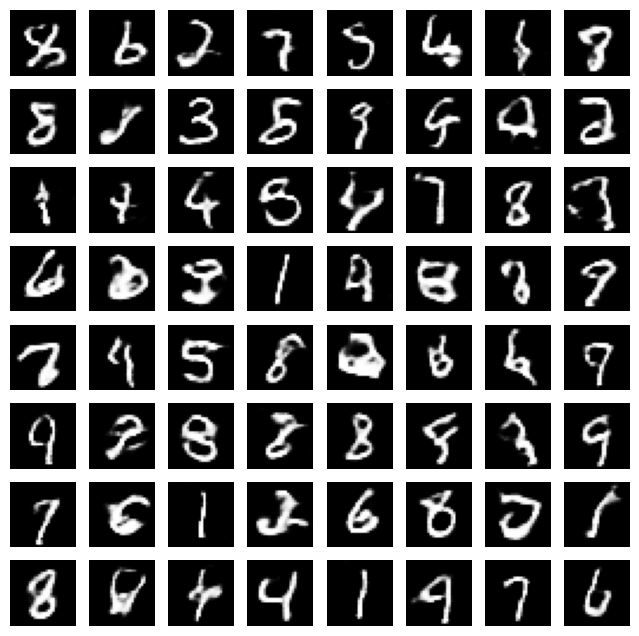

In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 1, random_noises[0], save = False, show = True)

In [ ]:
print("FID_score list:\t\t", fid_score_list.shape)
print("Training images:\t", train_images.shape)

FID_score list:		 (64, 28, 28, 1)
Training images:	 (60000, 28, 28, 1)


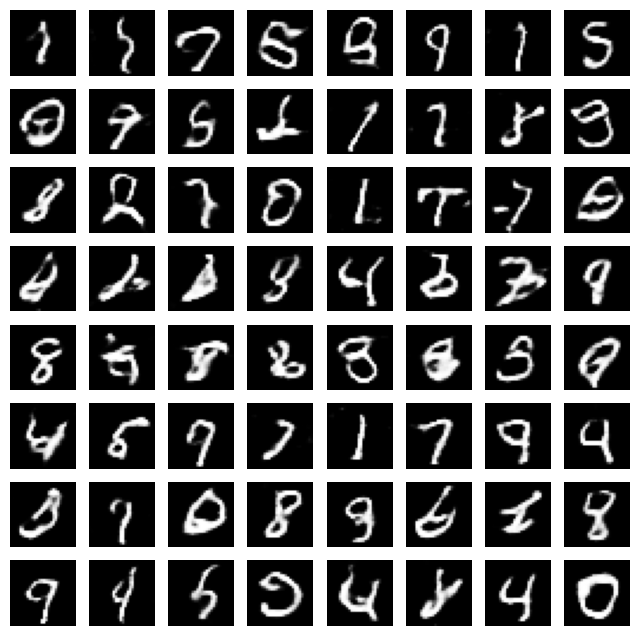

Outputs for  60  number of epochs and  128  batch size
execution time:  0.013901472091674805


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 2, random_noises[1], save = False, show = True)

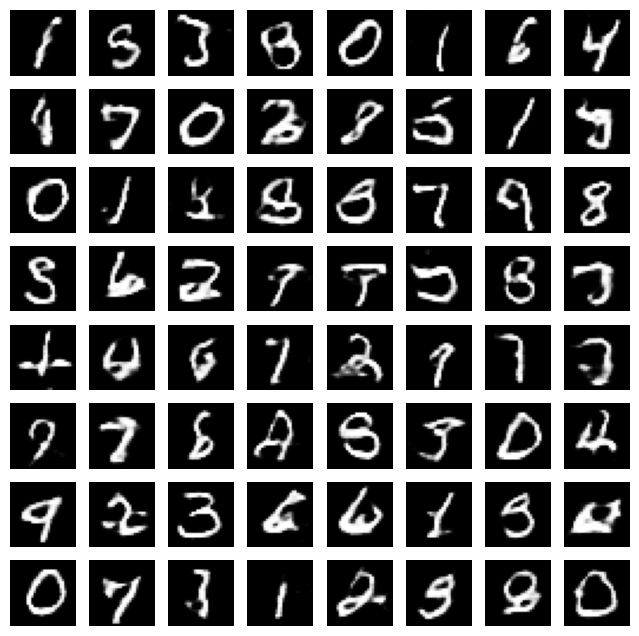

Outputs for  60  number of epochs and  128  batch size
execution time:  0.013151884078979492


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 3, random_noises[2], save = False, show = True)

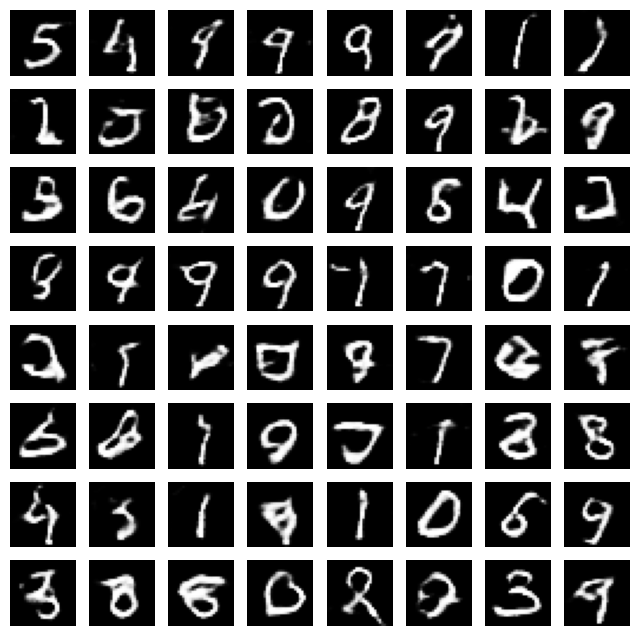

Outputs for  60  number of epochs and  128  batch size
execution time:  0.012662649154663086


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 4, random_noises[3], save = False, show = True)

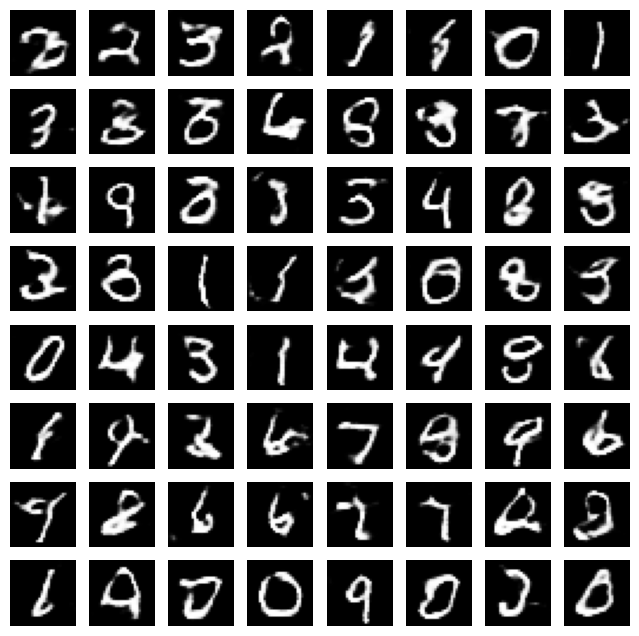

Outputs for  60  number of epochs and  128  batch size
execution time:  0.012160062789916992


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 5, random_noises[4], save = False, show = True)

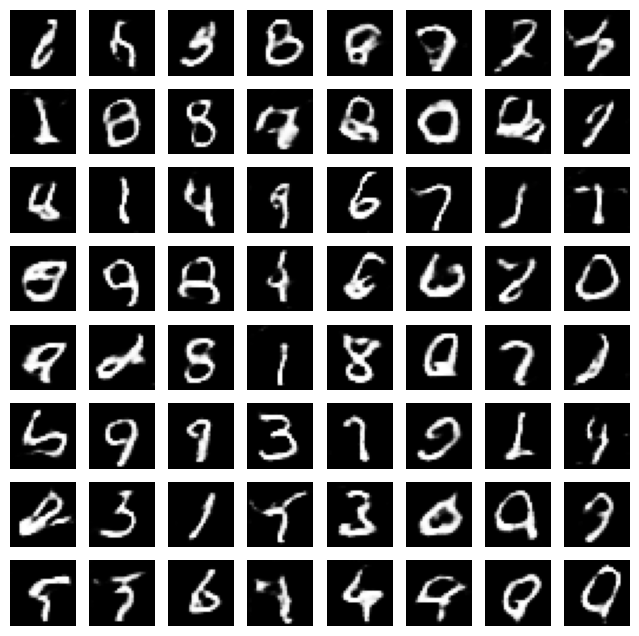

Outputs for  60  number of epochs and  128  batch size
execution time:  0.012624740600585938


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 6, random_noises[5],save = False, show = True)

In [ ]:
upperbound = int(10000/num_examples_to_generate)+2
print(upperbound)

158


In [ ]:
for t in range(7, upperbound):
    inference_step(EPOCHS, BATCH_SIZE, t,random_noises[t-1], save = False, show = False)

### Inference Step Time Execution

In [ ]:
print("Mean inference time: ", round(sum(inference_exe_time)/len(inference_exe_time), 4))

Mean inference time:  0.012


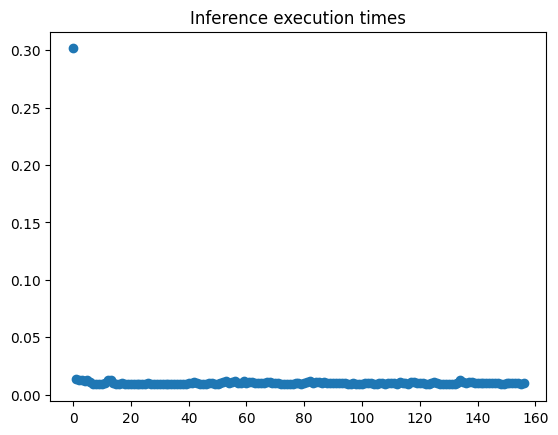

In [ ]:
## Weird thing (the first image takes a lot of time)
plot_inference_exe_time(inference_exe_time)

### FID score

In [ ]:
print(train_images.shape)
print(fid_score_list.shape)

(60000, 28, 28, 1)
(10048, 28, 28, 1)


In [ ]:
from fid import FID_measure
import random
import gc

In [ ]:
gc.collect()

128977

In [ ]:
fid = FID_measure(gen_images_ = fid_score_list, train_set_ = train_images, labels_ = train_labels)
train_set_shrinked, train_labels_shrinked = fid.sample_uniformly()

Middle of Constructor
Train set len :  60000
End of Constructor
Middle of sample uniformly
Train set len :  10000
End of sample uniformly


In [ ]:
score = fid.calculate_fid()
print('FID: %.3f' % score)

beginning of calc_fid
gen_images len :  10048
Check whether shrink is not None
Train set len :  10000
314/314 [==============================] - 39s 107ms/step
gen_images solved
313/313 [==============================] - 37s 119ms/step
train_set solved
sigma1 solved
sigma2 solved
FID: 4.482


### Calculating Mean and Variance of Distributions

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_images)

Flatten images:  (60000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(fid_score_list)

Flatten images:  (10048, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


### CNN for Predicting Generated Samples

In [ ]:
from keras.models import load_model
cnn = load_model('CNN.h5')

In [ ]:
preds_gen = cnn.predict(fid_score_list)
pred_labels_gen = np.argmax(preds_gen, axis=1)

314/314 [==============================] - 1s 2ms/step


In [ ]:
unique_elements, counts = np.unique(pred_labels_gen, return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

# print(pred_labels_gen.shape)
# print(train_labels.shape)

Frequency of Elements: 
{0: 646, 1: 650, 2: 1184, 3: 1872, 4: 649, 5: 1496, 6: 508, 7: 1490, 8: 777, 9: 776}


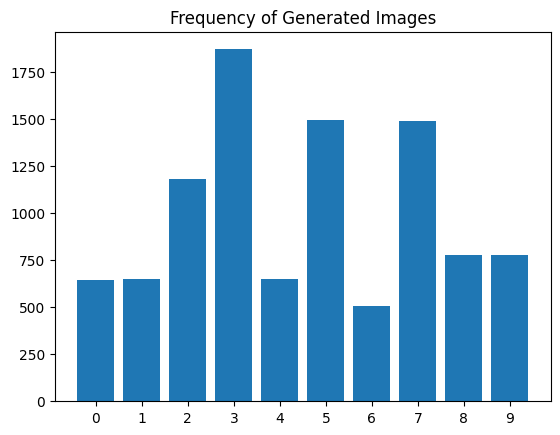

In [ ]:
plt.bar(unique_elements, counts)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

In [ ]:
# preds = cnn.predict(train_images)
# print(np.argmax(preds, axis=1).shape)

# print(train_images.shape)
# print(fid_score_list.shape)

# print(type(train_images))
# print(type(fid_score_list))

### Viewing Dimension-Reduced Samples

In [ ]:
print(vectorized_gen.shape)
print(vectorized_train.shape)

(10048, 784, 1)
(60000, 784, 1)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {class_label}')

    plt.legend()
    plt.show()

def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    # print(pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen, variance_PCA = 0.85)

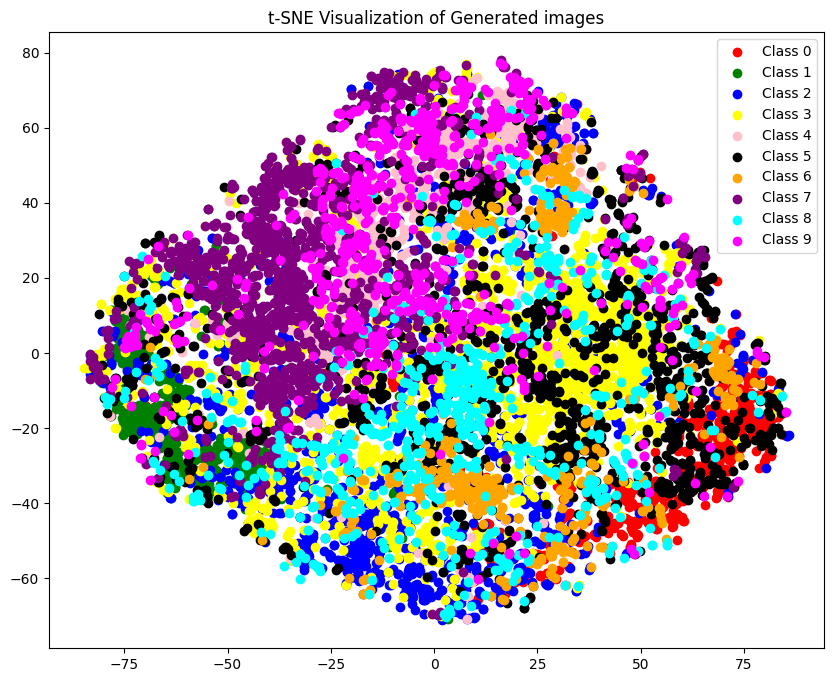

In [ ]:
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], pred_labels_gen, 't-SNE Visualization of Generated images')

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train, variance_PCA = 0.85)

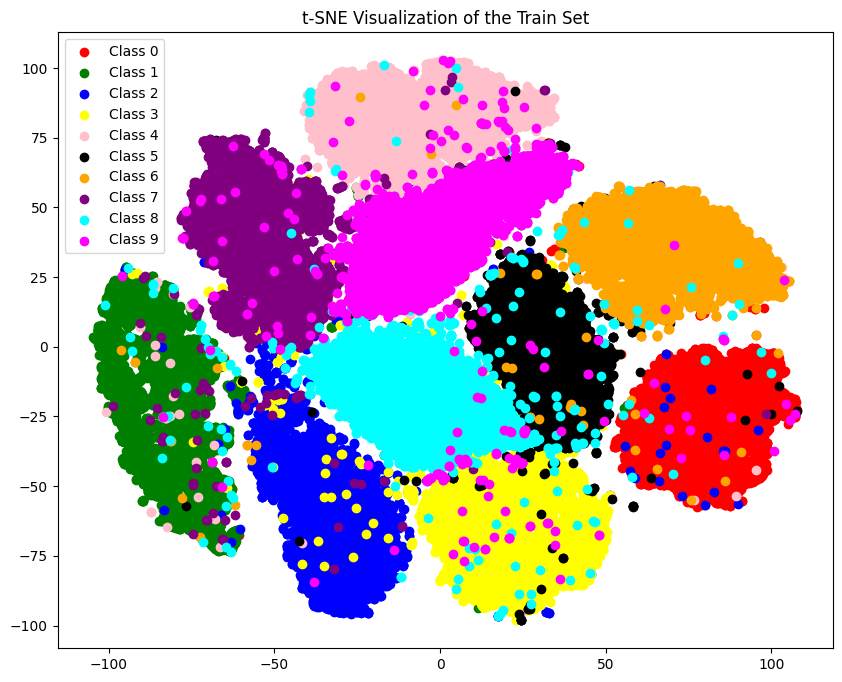

In [ ]:
scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], train_labels, 't-SNE Visualization of the Train Set')

## If the training set is not shrinked, use train_images in the calc_mu_and_sigma function and train_labels_shrinked
## instead of train_labels here

In [ ]:
print(reduced_dimension_train.shape)
print(reduced_dimension_gen.shape)

(60000, 2)
(10048, 2)


In [ ]:
gc.collect()

32330

### Precision, Recall, Density, Coverage measures

In [ ]:
_, _, vectorized_train_shrinked = calc_mu_and_sigma(train_set_shrinked)

Flatten images:  (10000, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
reduced_dimension_train_shrinked = map_diversity(data = vectorized_train_shrinked, variance_PCA = 0.85)

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train_shrinked,
                          fake_features = reduced_dimension_gen,
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 10000 Num fake: 10048
{'precision': 0.8579816878980892, 'recall': 0.8614, 'density': 0.7369426751592357, 'coverage': 0.7233}

----------------------------------

10 -Nearest Neighbors
Num real: 10000 Num fake: 10048
{'precision': 0.9227707006369427, 'recall': 0.8961, 'density': 0.7463674363057325, 'coverage': 0.8308}

----------------------------------

6 -Nearest Neighbors
Num real: 10000 Num fake: 10048
{'precision': 0.8792794585987261, 'recall': 0.8702, 'density': 0.743779856687898, 'coverage': 0.7666}

----------------------------------

3 -Nearest Neighbors
Num real: 10000 Num fake: 10048
{'precision': 0.7634355095541401, 'recall': 0.7954, 'density': 0.7060443205944799, 'coverage': 0.5696}

----------------------------------

2 -Nearest Neighbors
Num real: 10000 Num fake: 10048
{'precision': 0.649781050955414, 'recall': 0.6772, 'density': 0.6375398089171974, 'coverage': 0.4132}

----------------------------------

1 -Nearest Neighbors
Num real: 10000